In [1]:
import sys
sys.path.append("./../../src")
from visualizer_helper import Visualizer

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import preprocessing
from scipy.sparse import csr_matrix
import scipy
import pickle
import os
from annoy import AnnoyIndex
from scipy.sparse.linalg import inv
import hdbscan

large_file_path = "../../../large_data_files"

In [2]:
k_neighbors = 2000

In [3]:
A = pickle.load(open(os.path.join(large_file_path, "A_mknn_CLEANED_K{}_CSR.p".format(k_neighbors)), "rb"))

D = pickle.load(open("./data/D_mknn_K{}_CSR.p".format(k_neighbors), "rb"))
D_mc = pickle.load(open("./data/D_mc_mknn_K{}_CSR.p".format(k_neighbors), "rb"))

D_inv_sqrt = pickle.load(open("./data/D_mknn_inv_sqrt_K{}_CSR.p".format(k_neighbors), "rb"))
D_mc_inv_sqrt = pickle.load(open("./data/D_mc_mknn_inv_sqrt_K{}_CSR.p".format(k_neighbors), "rb"))

L = pickle.load(open("./data/L_mknn_CLEANED_K{}_CSR.p".format(k_neighbors), "rb"))
L_mc = pickle.load(open("./data/L_mc_mknn_CLEANED_K{}_CSR.p".format(k_neighbors), "rb"))

L_evals = pickle.load(open("./data/L_evals50_K{}.p".format(k_neighbors), "rb"))
L_evecs = pickle.load(open("./data/L_evecs50_K{}.p".format(k_neighbors), 'rb'))

L_mc_evals = pickle.load(open("./data/L_mc_evals50_K{}.p".format(k_neighbors), "rb"))
L_mc_evecs = pickle.load(open("./data/L_mc_evecs50_K{}.p".format(k_neighbors), "rb"))

In [ ]:
print(np.flip(L_evals))
plt.figure(figsize=(5,5))
ax = sns.scatterplot(range(L_evals.shape[0]), L_evals)

print(np.flip(L_mc_evals))
plt.figure(figsize=(5,5))
ax = sns.scatterplot(range(L_evals.shape[0]), L_mc_evals)

In [ ]:
def get_evec_df(evecs, top_k_evecs=5):
    k_evecs = evecs[:, -top_k_evecs:]
    evec_cols = ["Evec_{}".format(i) for i in range(top_k_evecs)]
    evec_df = pd.DataFrame(k_evecs, columns=evec_cols)
    return evec_df

L_evecdf = get_evec_df(L_evecs, top_k_evecs=10)
L_mc_evecdf = get_evec_df(L_mc_evecs, top_k_evecs=10)

In [ ]:
print(L_evecdf.describe())
print(L_mc_evecdf.describe())

In [4]:
def get_Y(evecs, drop_k_evecs = 1, keep_top_k_evecs = 5):
    X_top_k = evecs[:, -drop_k_evecs-keep_top_k_evecs:-drop_k_evecs]
    evecs_lengths_top_k = np.linalg.norm(X_top_k, axis=1)
    Y_top_k = X_top_k / evecs_lengths_top_k[:, None]
    return Y_top_k

keep_k_evecs=20
Y = get_Y(L_evecs, drop_k_evecs=2, keep_top_k_evecs=keep_k_evecs)
Y_mc = get_Y(L_mc_evecs, drop_k_evecs=2, keep_top_k_evecs=keep_k_evecs)

print(Y.shape, Y_mc.shape)

(46498, 20) (46498, 20)


In [5]:
visualizer = Visualizer()
lc=100

try:
    Y_umap_2d = pickle.load(open("./data/Y_umap_2d_K{}_topkevecs{}_lc{}.p".format(k_neighbors, keep_k_evecs, lc), 'rb'))
    Y_umap_3d = pickle.load(open("./data/Y_umap_3d_K{}_topkevecs{}_lc{}.p".format(k_neighbors, keep_k_evecs, lc), 'rb'))

    Y_mc_umap_2d = pickle.load(open("./data/Y_umap_2d_mc_K{}_topkevecs{}_lc{}.p".format(k_neighbors, keep_k_evecs, lc), 'rb'))
    Y_mc_umap_3d = pickle.load(open("./data/Y_umap_3d_mc_K{}_topkevecs{}_lc{}.p".format(k_neighbors, keep_k_evecs, lc), 'rb'))
except FileNotFoundError:
    print("Error: 1 or more umap files not found")
    Y_umap_2d = visualizer.umap_embedding(Y, n_components=2, lc=lc)
    Y_umap_3d = visualizer.umap_embedding(Y, n_components=3, lc=lc)
    
    Y_mc_umap_2d = visualizer.umap_embedding(Y_mc, n_components=2, lc=lc)
    Y_mc_umap_3d = visualizer.umap_embedding(Y_mc, n_components=3, lc=lc)

    pickle.dump(Y_umap_2d, open("./data/Y_umap_2d_K{}_topkevecs{}_lc{}.p".format(k_neighbors, keep_k_evecs, lc), 'wb'))
    pickle.dump(Y_umap_3d, open("./data/Y_umap_3d_K{}_topkevecs{}_lc{}.p".format(k_neighbors, keep_k_evecs, lc), 'wb'))

    pickle.dump(Y_mc_umap_2d, open("./data/Y_umap_2d_mc_K{}_topkevecs{}_lc{}.p".format(k_neighbors, keep_k_evecs, lc), 'wb'))
    pickle.dump(Y_mc_umap_3d, open("./data/Y_umap_3d_mc_K{}_topkevecs{}_lc{}.p".format(k_neighbors, keep_k_evecs, lc), 'wb'))

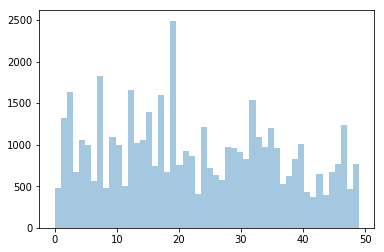

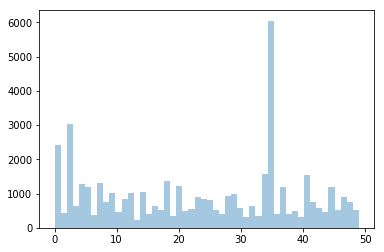

In [6]:
knn_clusters = 50

try:
    Y_cluster_labels = pickle.load(open("./data/cluster_labels_K{}_knn{}_topkevecs{}.p".format(k_neighbors, knn_clusters, keep_k_evecs), 'rb'))
    Y_mc_cluster_labels = pickle.load(open("./data/cluster_labels_mc_K{}_knn{}_topkevecs{}.p".format(k_neighbors, knn_clusters, keep_k_evecs), 'rb'))
except FileNotFoundError:
    print("running Kmeans")
    
    Y_kmeans = KMeans(n_clusters=knn_clusters).fit(Y)
    Y_mc_kmeans = KMeans(n_clusters=knn_clusters).fit(Y_mc)

    Y_cluster_labels = Y_kmeans.labels_    
    Y_mc_cluster_labels = Y_mc_kmeans.labels_

    pickle.dump(Y_cluster_labels, open("./data/cluster_labels_K{}_knn{}_topkevecs{}.p".format(k_neighbors, knn_clusters, keep_k_evecs), "wb"))
    pickle.dump(Y_mc_cluster_labels, open("./data/cluster_labels_mc_K{}_knn{}_topkevecs{}.p".format(k_neighbors, knn_clusters, keep_k_evecs), "wb"))

    print("Cluster labels:", np.unique(Y_cluster_labels))
    
plt.figure()
sns.distplot(Y_cluster_labels, bins=knn_clusters, kde=False)
plt.figure()
sns.distplot(Y_mc_cluster_labels, bins=knn_clusters, kde=False)

In [ ]:
alpha = 1

filename_2d = "./figures/umap2d_K{}_topkevecs{}_knn{}".format(k_neighbors, keep_k_evecs, knn_clusters)
filename_3d = "./figures/umap3d_K{}_topkevecs{}_knn{}".format(k_neighbors, keep_k_evecs, knn_clusters)   

filename_mc_2d = "./figures/umap2d_mc_K{}_topkevecs{}_knn{}".format(k_neighbors, keep_k_evecs, knn_clusters)
filename_mc_3d = "./figures/umap3d_mc_K{}_topkevecs{}_knn{}".format(k_neighbors, keep_k_evecs, knn_clusters)

visualizer.plot2d(
    X=Y_umap_2d, 
    filename=filename_2d, 
    colors=Y_cluster_labels,
    alpha = alpha
)

visualizer.plot3d(
    X=Y_umap_3d, 
    filename=filename_3d, 
    colors=Y_cluster_labels,
    alpha = alpha
)

visualizer.plot2d(
    X=Y_mc_umap_2d, 
    filename=filename_mc_2d, 
    colors=Y_mc_cluster_labels,
    alpha = alpha
)
visualizer.plot3d(
    X=Y_mc_umap_3d, 
    filename=filename_mc_3d, 
    colors=Y_mc_cluster_labels,
    alpha = alpha
)

In [7]:
def sort_by_cluster_membership(M, cluster_labels):
    sorted_cluster_labels = sorted(list(enumerate(cluster_labels.tolist())), key=lambda p: p[1])
    clusters_by_idx = [p[0] for p in sorted_cluster_labels]
    return M[clusters_by_idx][:, clusters_by_idx]

L_sorted = sort_by_cluster_membership(L, Y_cluster_labels)
L_mc_sorted = sort_by_cluster_membership(L_mc, Y_mc_cluster_labels)

A_sorted = sort_by_cluster_membership(A, Y_cluster_labels)
A_mc_sorted = sort_by_cluster_membership(A, Y_mc_cluster_labels)

print(L_sorted.shape, A_sorted.shape, L_mc_sorted.shape, A_mc_sorted.shape)

(46498, 46498) (46498, 46498) (46498, 46498) (46498, 46498)


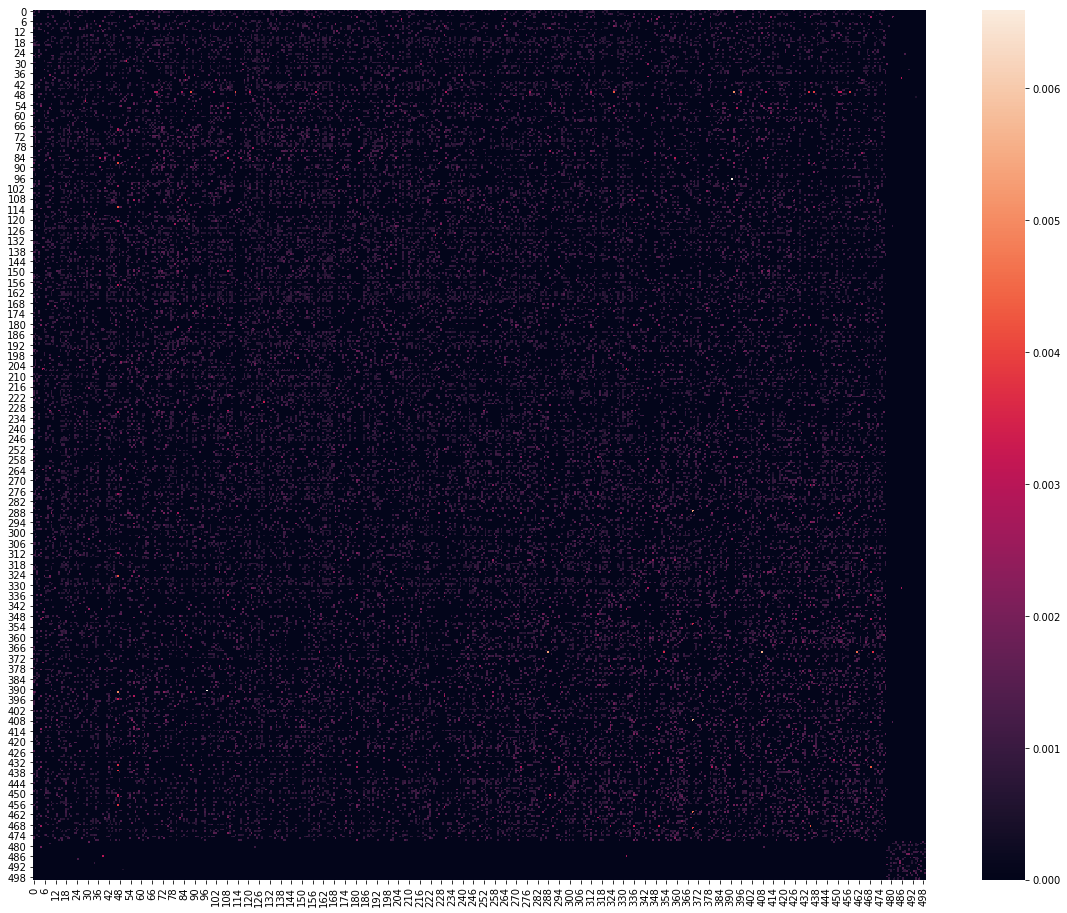

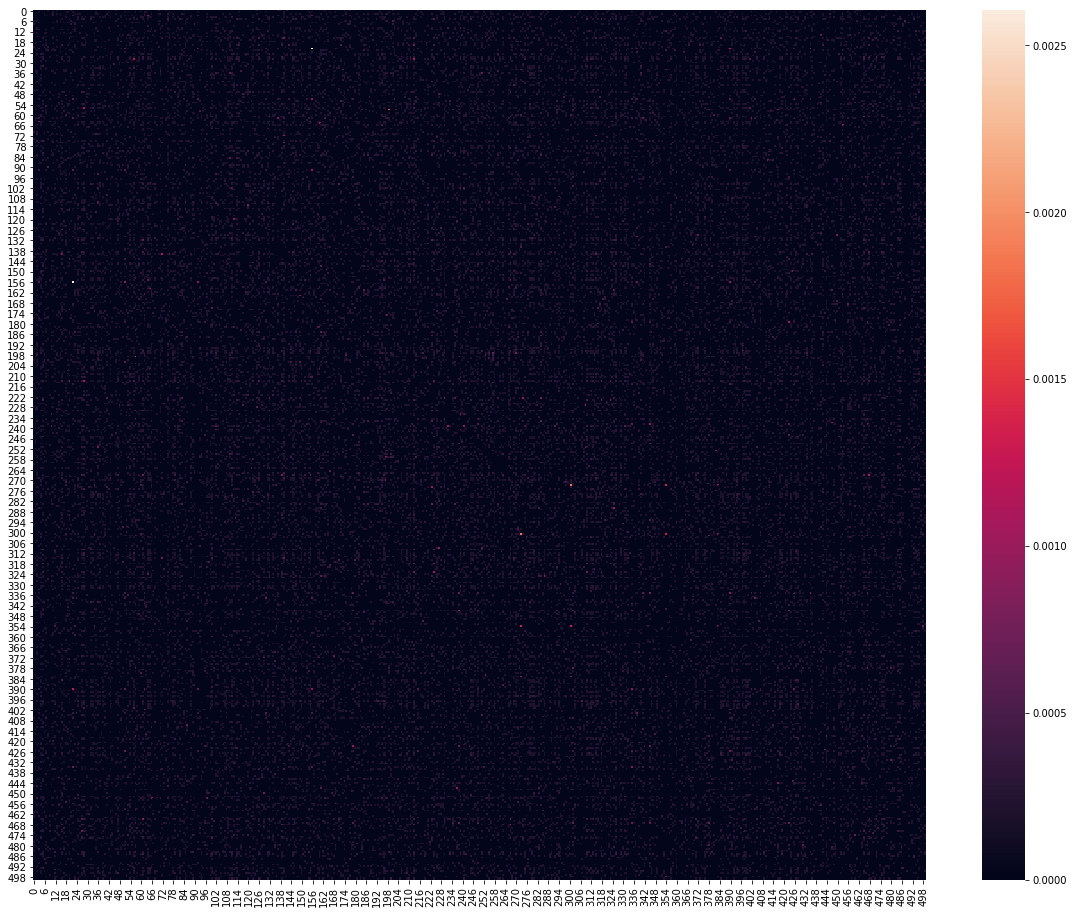

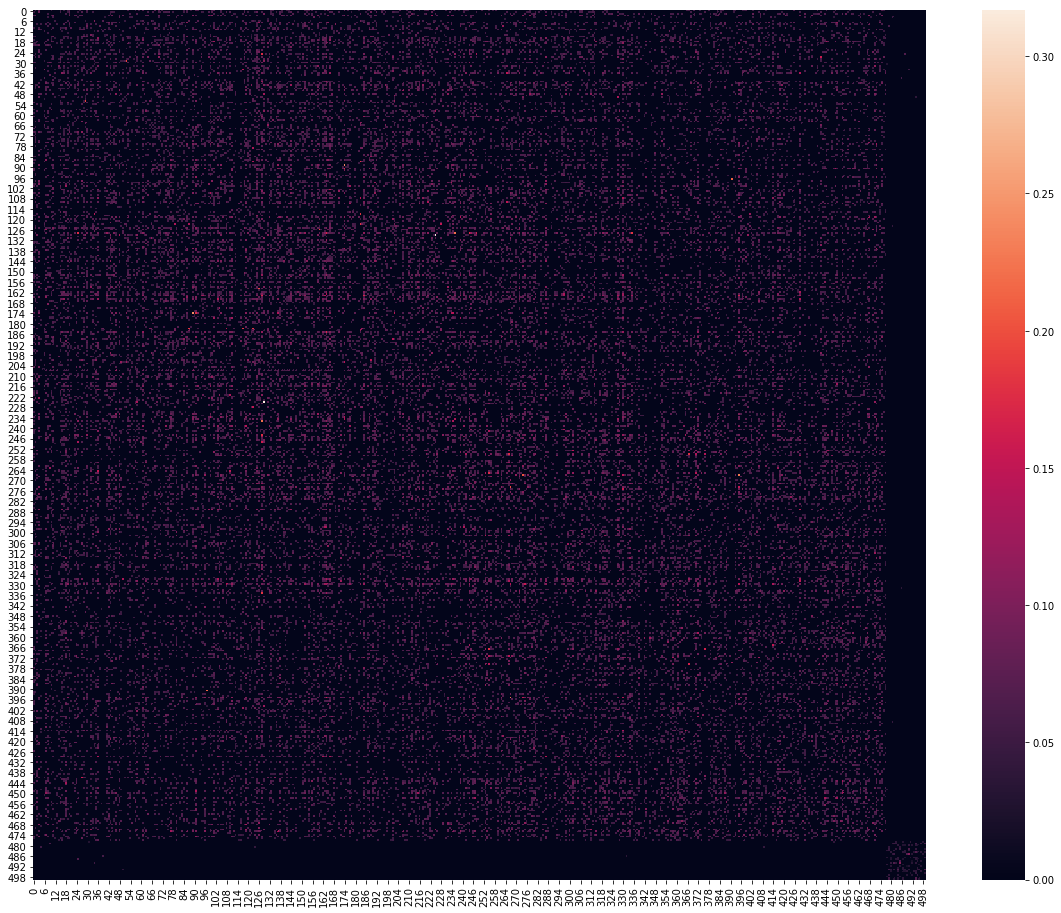

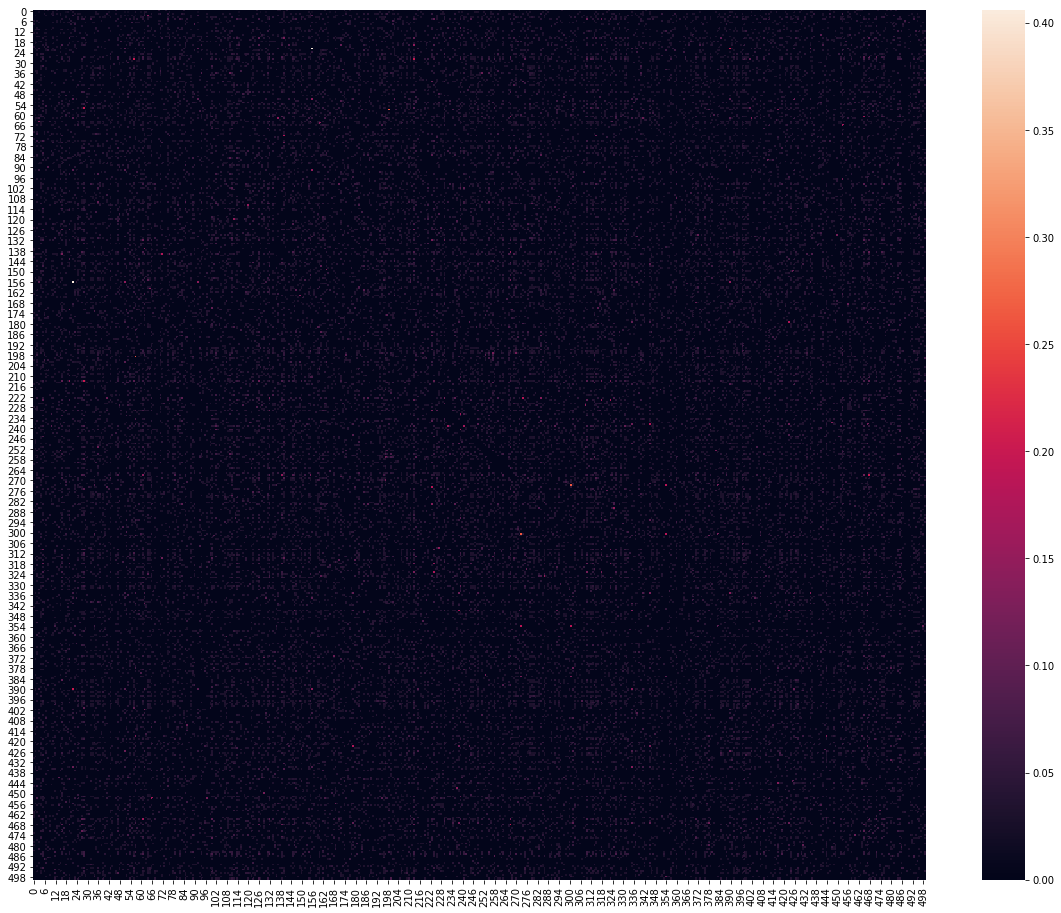

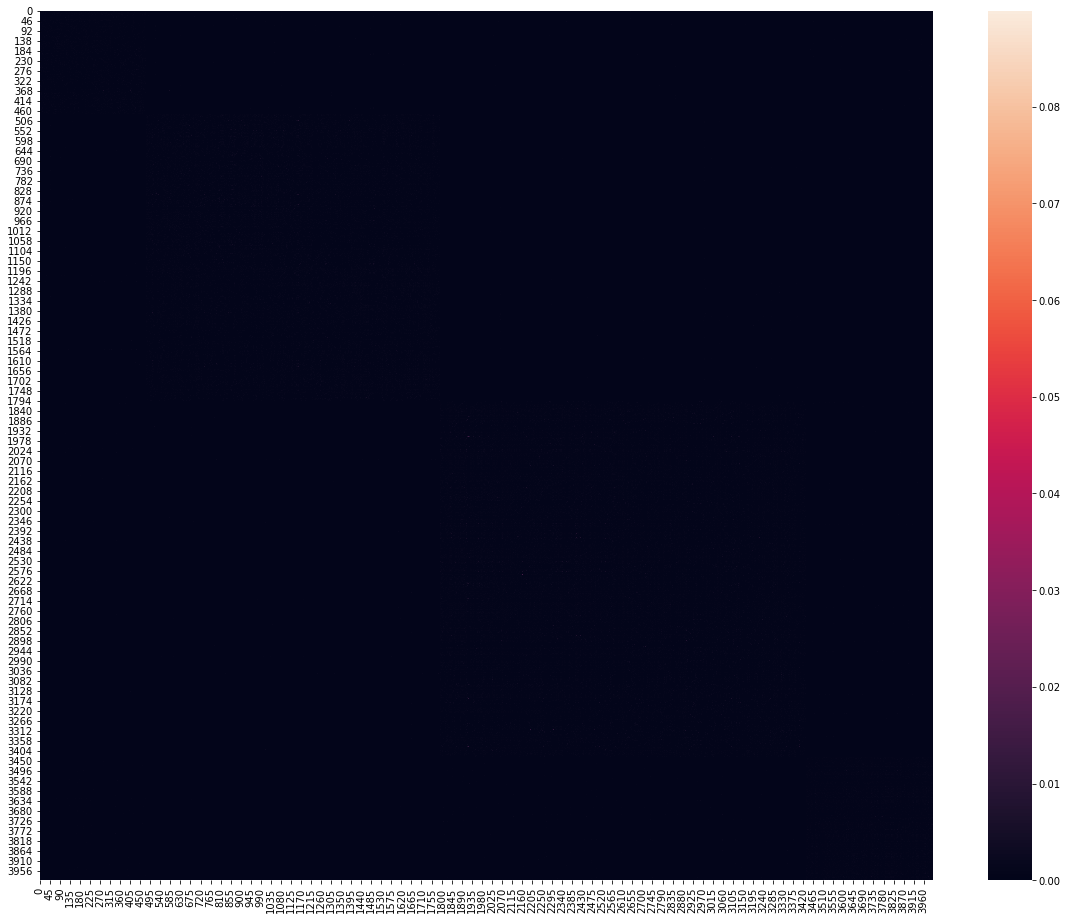

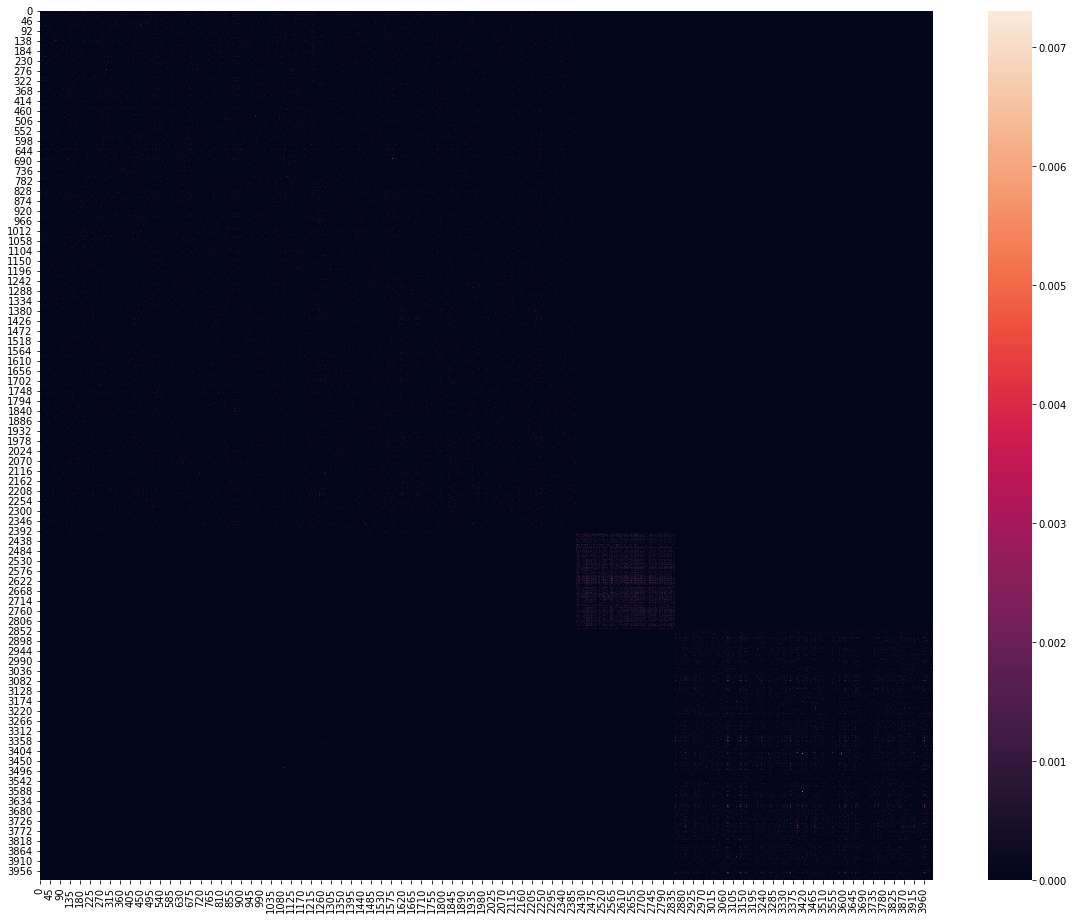

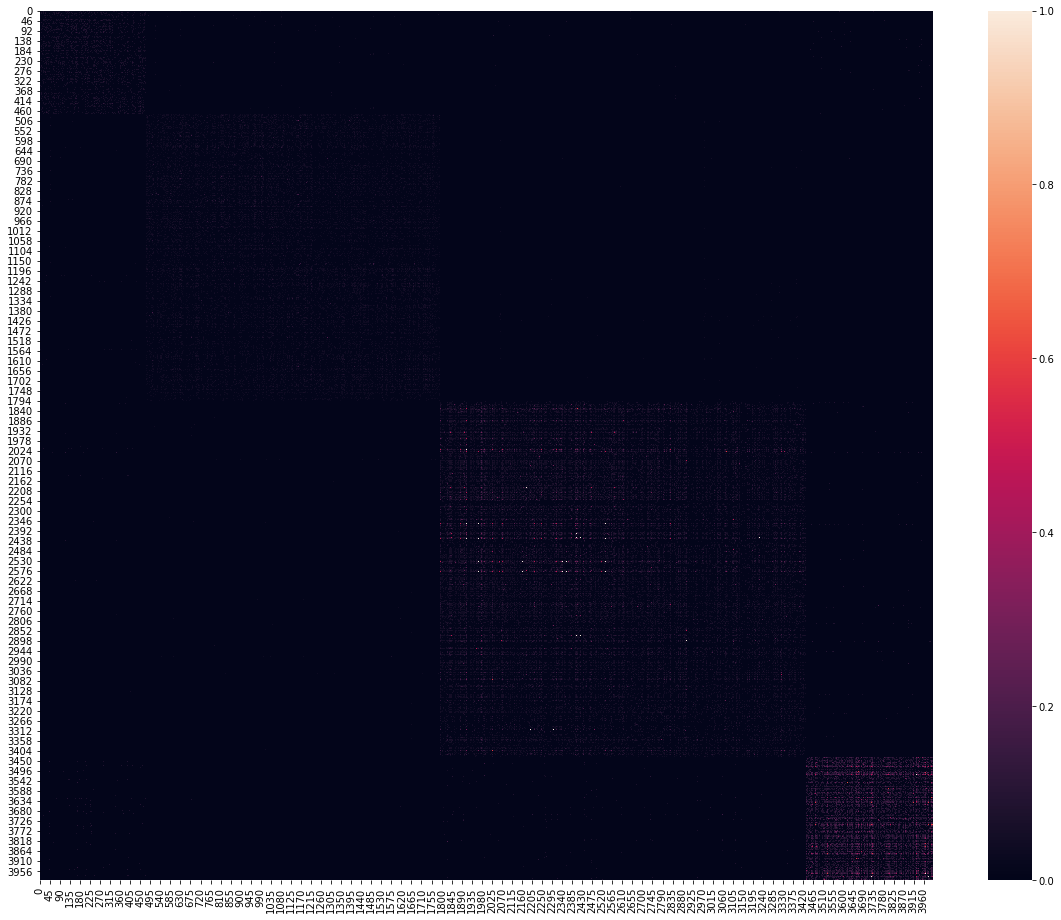

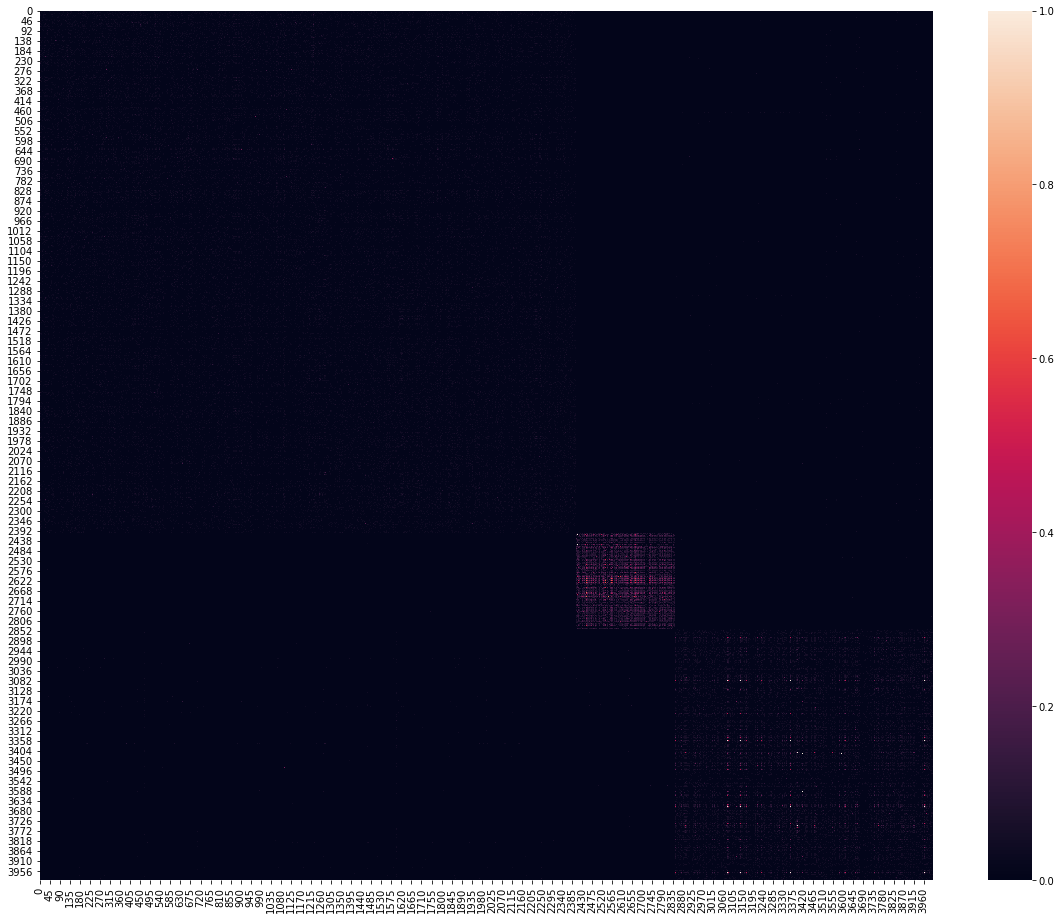

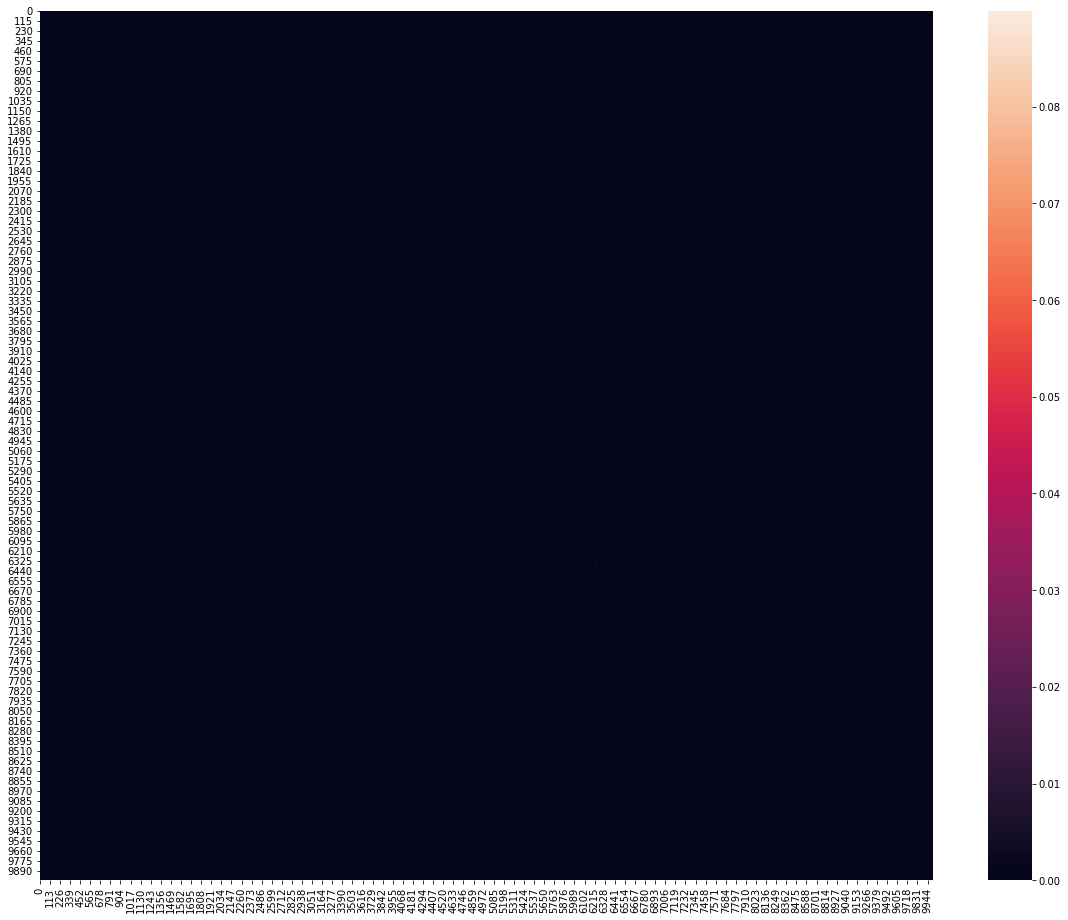

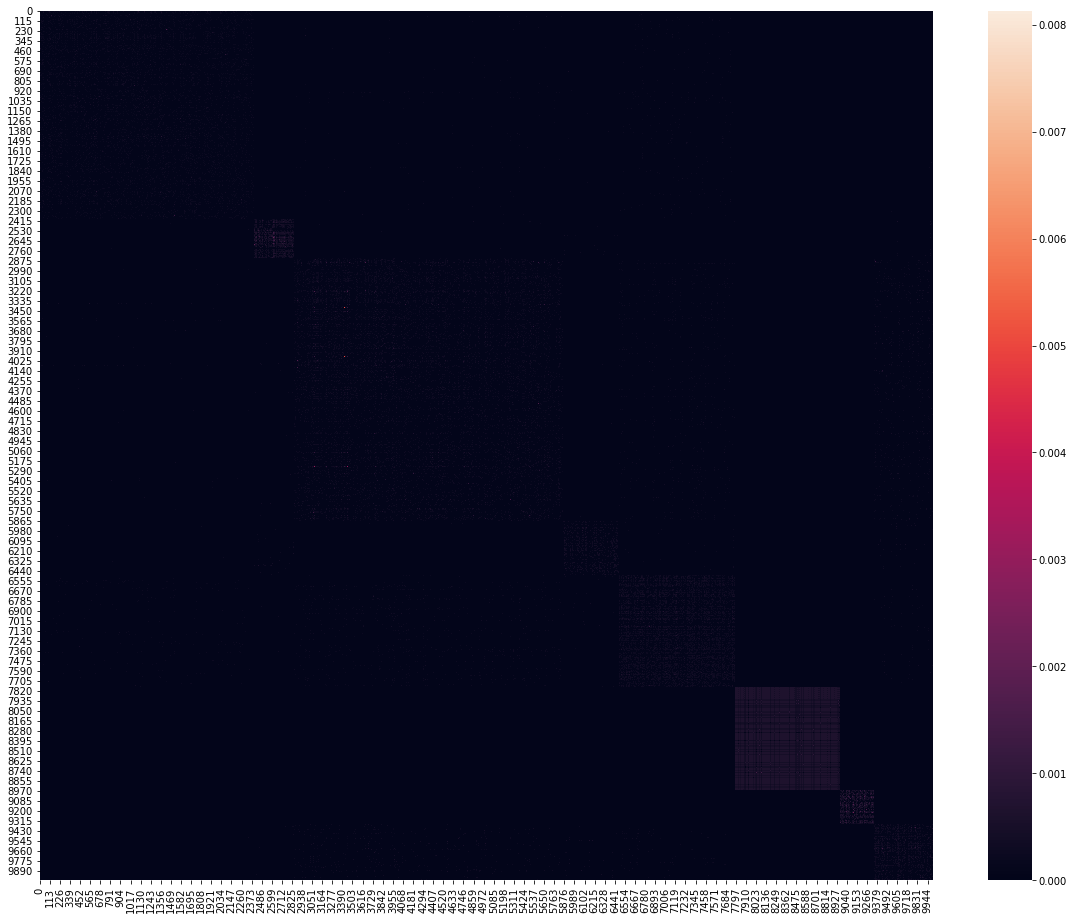

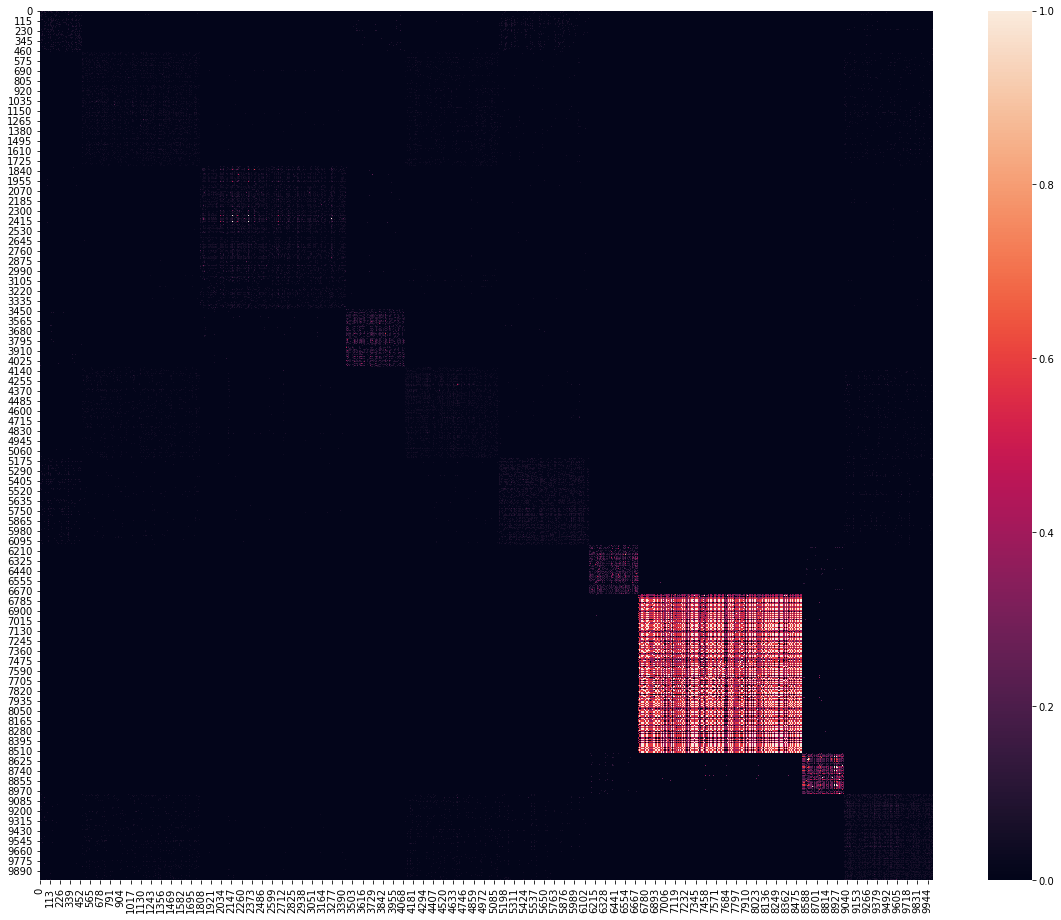

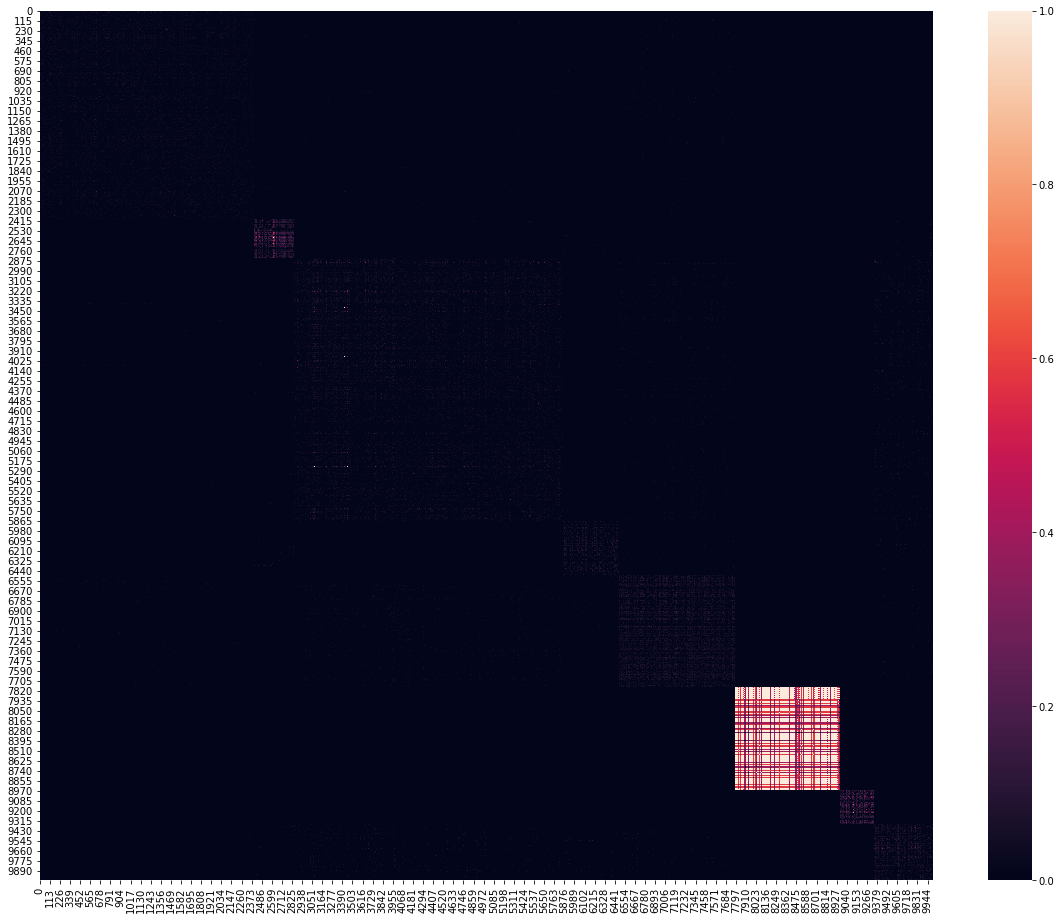

In [8]:
# sns.heatmap(L_sorted[:100, :100].toarray())
plot_dims = [500, 4000, 10000]
plot_vars = [L_sorted, L_mc_sorted, A_sorted, A_mc_sorted]
plot_var_names = ['L_sorted', 'L_mc_sorted', 'A_sorted', 'A_mc_sorted']
for dim in plot_dims:
    for v in range(len(plot_vars)):
        var = plot_vars[v]
        varname = plot_var_names[v]
        
        plt.figure(figsize=(20,16))
        sns.heatmap((var[:dim, :dim]).toarray())
        plt.savefig("./figures/heatmap_{}_knn{}_kevecs{}_{}x{}.png".format(varname, knn_clusters, keep_k_evecs, dim, dim))

In [ ]:
sns.distplot(Y_cluster_labels, bins=knn_clusters)

In [ ]:
sns.distplot(Y_mc_cluster_labels, bins=knn_clusters)